In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import os
import time
from tqdm.autonotebook import tqdm

%matplotlib inline

In [ ]:
img_augmentation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
    ])

In [ ]:
class LouisianaDataset(Dataset):
    def __init__(self, type):
        if type == 'train':
            self.df = pd.read_csv("/content/drive/MyDrive/disaster/train.csv")
            self.image_folder = "/content/drive/MyDrive/disaster/train/"
        else:
            self.df = pd.read_csv("/content/drive/MyDrive/disaster/test.csv")
            self.image_folder = "/content/drive/MyDrive/disaster/test/"

        self.imgs = self.df[self.df['Normal']==1]
        self.imgs = self.imgs['Image ID'].values

    def __getitem__(self, idx):
        before_img_path = os.path.join(self.image_folder, self.imgs[idx])
        flood_img_path = glob(self.image_folder+self.imgs[idx].split('.')[0]+'_*')[0]

        before_img = Image.open(before_img_path)
        before_img = img_augmentation(before_img)
        flood_img = Image.open(flood_img_path)
        flood_img = img_augmentation(flood_img)

        label = int(flood_img_path.split('_')[-1].split('.')[0])

        return (before_img,flood_img,torch.as_tensor([label], dtype=torch.float))

    def __len__(self):
        return len(self.imgs)

In [ ]:
train_data = LouisianaDataset('train')
print('No. of training samples: ',len(train_data))
valid_data = LouisianaDataset('valid')
print('No. of validation samples: ',len(valid_data))

No. of training samples:  135
No. of validation samples:  26


In [ ]:
num_workers = 0
bs = 8

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=bs, shuffle=True, num_workers=num_workers)

In [ ]:
import torchvision.models as models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.network1 = models.mobilenet_v2(pretrained=True)
        self.network2 = models.mobilenet_v2(pretrained=True)
        self.distance = torch.nn.PairwiseDistance(keepdim=True)
        self._bn = torch.nn.BatchNorm1d(1)
        self._act = torch.nn.Sigmoid()

    def forward(self, input1, input2):
        feats1 = self.network1(input1)
        feats2 = self.network2(input2)
        distance = self.distance(feats1, feats2)
        output = self._bn(distance)
        output = self._act(output)
        return output


In [ ]:
%%capture
model = SiameseNetwork()
model.cuda()

In [ ]:
train_losses = []
valid_losses = []

In [ ]:
num_epochs = 25
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [ ]:
start_ts = time.time()
for epoch in range(num_epochs):
    # ----------------- TRAINING  --------------------
    train_loss = 0.0
    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Train_loss: ", total=len(train_loader))
    # set model to training
    model.train()

    for i, data in progress:
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # training step for single batch
        model.zero_grad()
        optimizer.zero_grad()
        pred = model(img0,img1)
        loss = criterion(pred,label)
        loss.backward()
        optimizer.step()

        # getting training quality data
        train_loss += loss.item()

        # updating progress bar
        progress.set_description("Train_loss: {:.4f}".format(train_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    train_loss = train_loss/len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, training loss: {train_loss}")

    train_losses.append(train_loss)

    # ----------------- VALIDATION --------------------

    valid_loss = 0.0
    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(valid_loader), desc="Valid_loss: ", total=len(valid_loader))
    # set model to training
    model.eval()

    for i, data in progress:
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        pred = model(img0,img1)
        loss = criterion(pred,label)

        # getting validation quality data
        valid_loss += loss.item()

        # updating progress bar
        progress.set_description("Valid_loss: {:.4f}".format(train_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    valid_loss = valid_loss/len(valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, valid loss: {valid_loss}")

    valid_losses.append(valid_loss)

    print('- '*50)

print(f"Training time: {time.time()-start_ts}s")

Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/25, training loss: 0.6080107005203471


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, valid loss: 0.5851250439882278
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25, training loss: 0.46278595223146324


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, valid loss: 0.7261947616934776
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25, training loss: 0.4516466382671805


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, valid loss: 0.46216174215078354
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25, training loss: 0.4405915702090544


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, valid loss: 0.4552583768963814
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25, training loss: 0.40843424376319437


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, valid loss: 0.4480507895350456
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25, training loss: 0.3918255830512327


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, valid loss: 0.6454549357295036
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25, training loss: 0.39300428243244395


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, valid loss: 0.5644837766885757
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25, training loss: 0.36319493896820965


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, valid loss: 0.5010623708367348
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25, training loss: 0.38968818503267627


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, valid loss: 0.46918362379074097
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25, training loss: 0.38969485198750214


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, valid loss: 0.3769877701997757
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25, training loss: 0.39261072172838096


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, valid loss: 0.4040910229086876
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25, training loss: 0.34487779526149526


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, valid loss: 0.4702393412590027
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25, training loss: 0.33673099209280577


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, valid loss: 0.44827865064144135
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25, training loss: 0.3324558103785795


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, valid loss: 0.40489017590880394
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25, training loss: 0.38983529630829306


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, valid loss: 0.39287011325359344
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25, training loss: 0.33292722702026367


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, valid loss: 0.37947043031454086
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25, training loss: 0.33610006115015817


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, valid loss: 0.36890190467238426
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25, training loss: 0.33292383481474486


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, valid loss: 0.4112612158060074
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25, training loss: 0.325446779237074


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, valid loss: 0.4164903685450554
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25, training loss: 0.34932442097102895


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, valid loss: 0.3905677944421768
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25, training loss: 0.3097001577124876


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, valid loss: 0.39181140810251236
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25, training loss: 0.3417842598522411


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, valid loss: 0.354617640376091
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25, training loss: 0.31509356463656707


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, valid loss: 0.42723647505044937
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25, training loss: 0.29814159344224367


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, valid loss: 0.36939653009176254
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25, training loss: 0.3014147088808172


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, valid loss: 0.35246551036834717
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training time: 413.2693064212799s


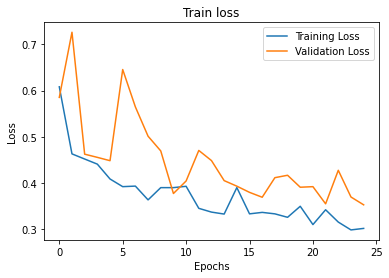

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")

plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.savefig('traing_progress.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

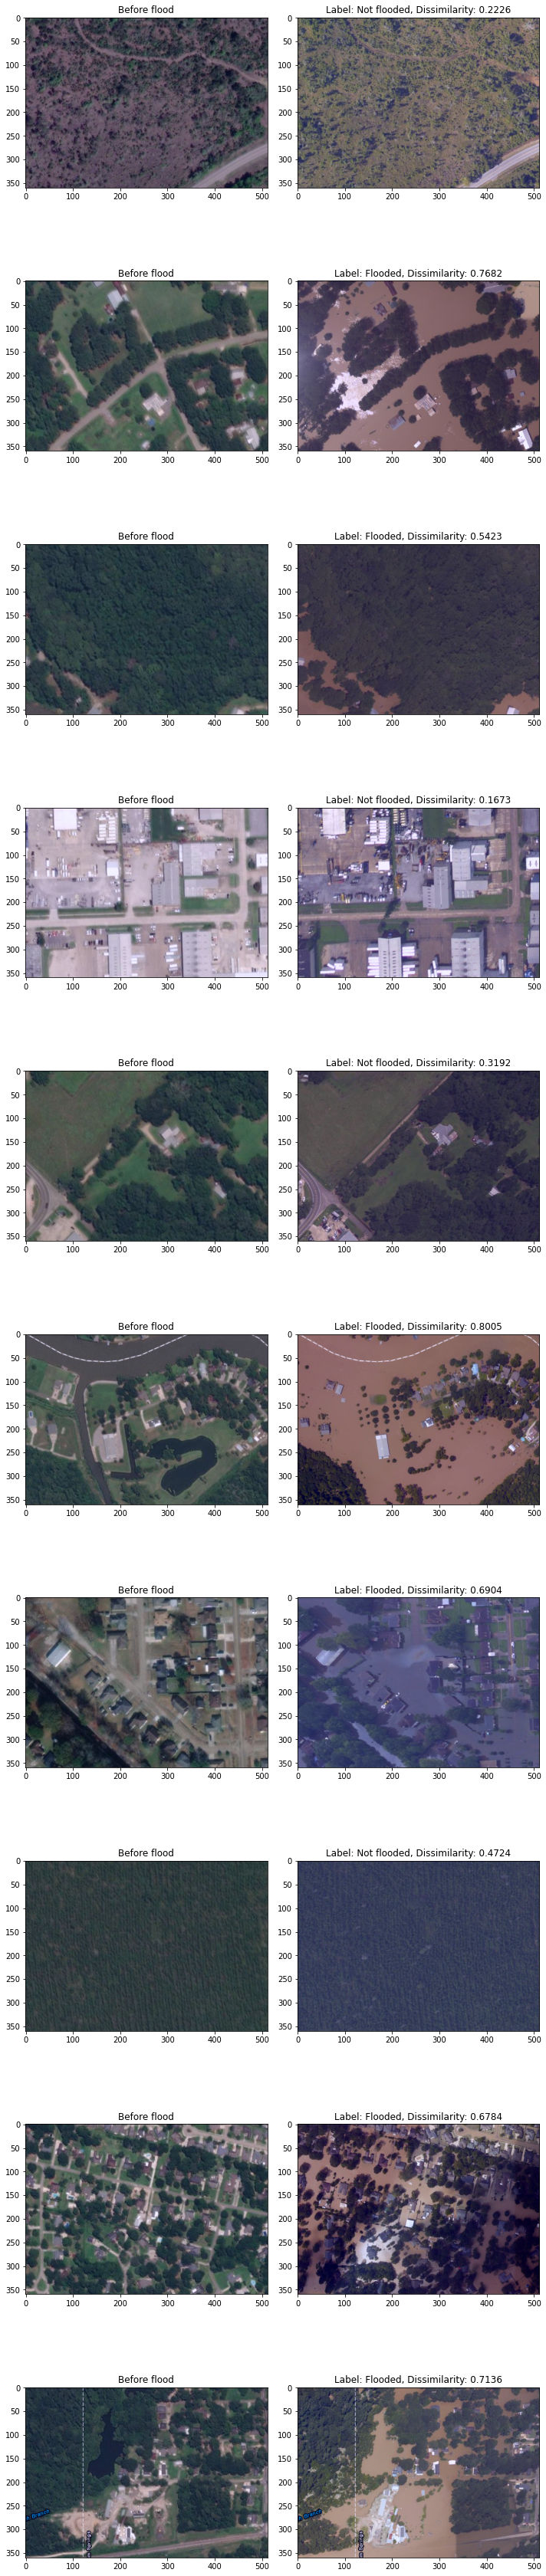

In [ ]:
print("Inference")

mean = np.array([0.456, 0.406, 0.485])
std = np.array([0.224, 0.225, 0.229])

model.eval()

columns = 2; rows = 10
fig=plt.figure(figsize=(columns*5, rows*5))
for i in range(0, columns*rows, 2):
    image0, image1, label = valid_data[i]
    img0, img1 = image0[None,:,:,:], image1[None,:,:,:]
    img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
    pred = model(img0,img1)

    fig.add_subplot(rows,columns,i+1)
    image0 = image0.permute(1, 2, 0).numpy()
    image0 = image0 * std
    image0 = image0 + mean
    plt.imshow(image0)
    plt.title("Before flood")
    plt.tight_layout()
    fig.add_subplot(rows,columns,i+2)
    image1 = image1.permute(1, 2, 0).numpy()
    image1 = image1 * std
    image1 = image1 + mean
    plt.imshow(image1)
    ftitle_true = 'Flooded' if int(label.cpu().detach().numpy())==1 else 'Not flooded'
    plt.title('Label: '+ftitle_true +', Dissimilarity: '+str(round(float(pred.cpu().detach().numpy()), 4)))
    plt.tight_layout()

plt.show()

Summary of prediction

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [ ]:
!cp /content/drive/MyDrive/Colab Notebooks/Untitled1.ipynb ./

cp: cannot stat '/content/drive/MyDrive/Colab': No such file or directory
cp: cannot stat 'Notebooks/Untitled1.ipynb': No such file or directory


In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Untitled1.ipynb')

--2022-03-13 10:36:57--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-03-13 10:36:58 (18.7 MB/s) - ‘colab_pdf.py’ saved [1864/1864]





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Untitled1.ipynb to pdf
[NbConvertApp] Support files will be in Untitled1_files/
[NbConvertApp] Making directory ./Untitled1_files
[NbConvertApp] Writing 81903 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './note

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'